<a href="https://colab.research.google.com/github/KingsleyCE9/Project-1/blob/main/Week5_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required packages

In [34]:
# Cell 1: install libraries (run once)
!pip install -q imbalanced-learn shap python-docx xgboost
print("Installed packages (if needed).")


Installed packages (if needed).


Imports

In [ ]:
# Cell 2: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from google.colab import files

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib
from docx import Document
from docx.shared import Inches

print("Imports done.")


Upload heart.csv

In [35]:
# Cell 3: upload via dialog (alternative)
uploaded = files.upload()   # click the Choose Files button that appears and select heart.csv


Saving heart.csv to heart (1).csv


Load and inspect the dataset

In [36]:
# Cell 4: load and inspect
df = pd.read_csv("heart.csv")   # if you uploaded with a different name, replace here
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Choose / confirm the label column

In [37]:
# Cell 5: set the label column - EDIT if your label column name is not 'target'
label_col = 'target'   # <<--- if you see another name in df.columns (like 'HeartDisease' etc), change it here

if label_col not in df.columns:
    print(f"Label column '{label_col}' NOT found. Columns are:\n{df.columns.tolist()}")
else:
    print(f"Label column '{label_col}' found.")
    print(df[label_col].value_counts())


Label column 'target' found.
target
1    526
0    499
Name: count, dtype: int64


Create X and y

In [38]:
# Cell 6: create features and target
X = df.drop(columns=[label_col])
y = df[label_col]
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1025, 13) y shape: (1025,)


Auto-detect numeric & categorical columns

In [39]:
# Cell 7: auto-detect numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# Convert integer columns with few unique values to categorical (common in heart dataset)
for col in X.select_dtypes(include=['int64','int32']).columns:
    if X[col].nunique() <= 10 and col not in cat_cols:
        cat_cols.append(col)
        if col in num_cols:
            num_cols.remove(col)

print("Numeric columns (detected):", num_cols)
print("Categorical columns (detected):", cat_cols)


Numeric columns (detected): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical columns (detected): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


Build preprocessing + model pipelines

In [40]:
# Cell 8: build preprocessing and pipelines (correct OneHotEncoder usage)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Random Forest pipeline with SMOTE
rf_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

print("Pipelines ready.")


Pipelines ready.


Train / Test split

In [41]:
# Cell 9: train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (820, 13) Test: (205, 13)


Train baseline models

In [42]:
# Cell 10: train models
print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1]

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]

print("Training done.")


Training Logistic Regression...
Training Random Forest...
Training done.


View basic evaluation metrics

In [43]:
# Cell 11: print metrics for both
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_lr), 3))
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_rf), 3))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.894     0.840     0.866       100
           1      0.856     0.905     0.880       105

    accuracy                          0.873       205
   macro avg      0.875     0.872     0.873       205
weighted avg      0.874     0.873     0.873       205

ROC AUC: 0.944

=== Random Forest ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       100
           1      1.000     1.000     1.000       105

    accuracy                          1.000       205
   macro avg      1.000     1.000     1.000       205
weighted avg      1.000     1.000     1.000       205

ROC AUC: 1.0


Confusion matrix & save

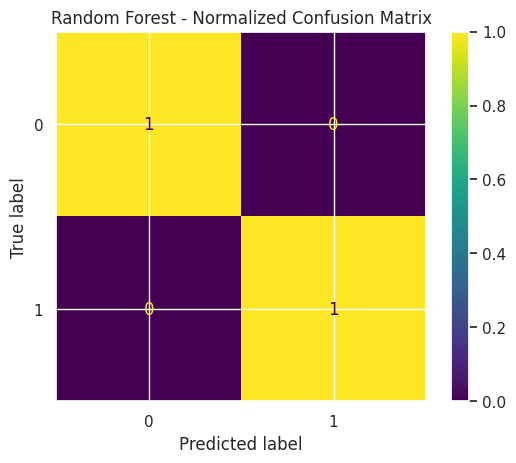

<Figure size 640x480 with 0 Axes>

In [44]:
# Cell 12: confusion matrix for Random Forest (normalized)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, normalize='true')
plt.title("Random Forest - Normalized Confusion Matrix")
plt.show()
plt.savefig("confusion_matrix_rf.png", bbox_inches='tight')


In [45]:
from google.colab import files
files.download("confusion_matrix_rf.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ROC and Precision-Recall curves

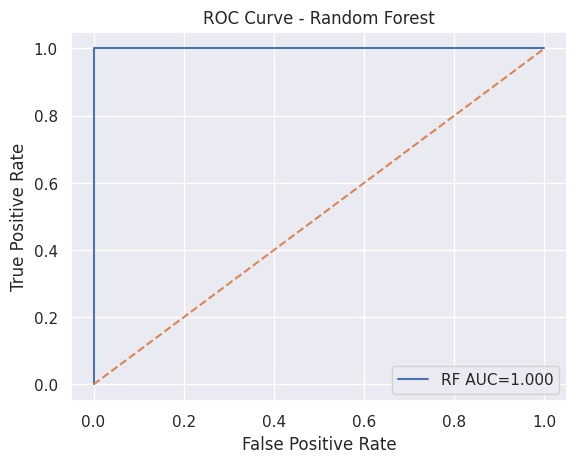

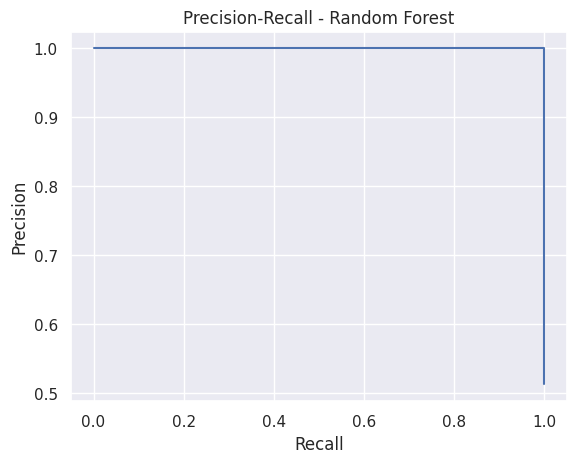

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# Cell 13: ROC and PR for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(); plt.plot(fpr, tpr, label=f'RF AUC={roc_auc_score(y_test,y_proba_rf):.3f}'); plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve - Random Forest"); plt.legend(); plt.savefig("roc_rf.png"); plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_proba_rf)
plt.figure(); plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall - Random Forest"); plt.savefig("pr_rf.png"); plt.show()

files.download("roc_rf.png")
files.download("pr_rf.png")


Cross-validation

In [47]:
# Cell 14: 5-fold CV for RF pipeline (prints mean scores)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','precision','recall','f1','roc_auc']
cv_res = cross_validate(rf_pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)
import numpy as np
for k in scoring:
    print(k, "mean:", np.mean(cv_res[f'test_{k}']).round(3))


accuracy mean: 1.0
precision mean: 1.0
recall mean: 1.0
f1 mean: 1.0
roc_auc mean: 1.0


Simple hyperparameter tuning example

In [49]:
# Assuming you have defined preprocessor, num_cols, cat_cols, etc.

# Random Forest pipeline with SMOTE
rf_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Logistic Regression pipeline (uses standard sklearn Pipeline, as it doesn't have SMOTE)
lr_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

Error analysis: inspect misclassified rows

In [50]:
# Cell 16: misclassified examples (Random Forest)
test_df = X_test.copy()
test_df['true'] = y_test.values
test_df['pred_rf'] = y_pred_rf
test_df['proba_rf'] = y_proba_rf

mis = test_df[test_df['true'] != test_df['pred_rf']]
print("Total misclassified:", mis.shape[0])
display(mis.head(10))


Total misclassified: 0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,true,pred_rf,proba_rf


SHAP feature importance

In [51]:
# Cell 17: SHAP summary (sample for speed)
try:
    preproc = rf_pipeline.named_steps['preproc']
    X_test_trans = preproc.transform(X_test)

    # get feature names helper
    def get_feature_names(preproc, num_cols, cat_cols):
        names = []
        if num_cols:
            names += num_cols
        if cat_cols:
            ohe = preproc.named_transformers_['cat'].named_steps['onehot']
            cat_names = ohe.get_feature_names_out(cat_cols).tolist()
            names += cat_names
        return names

    feature_names = get_feature_names(preproc, num_cols, cat_cols)
    import shap
    explainer = shap.TreeExplainer(rf_pipeline.named_steps['clf'])
    # sample 200 rows to speed up
    sample_idx = np.random.choice(X_test_trans.shape[0], min(200, X_test_trans.shape[0]), replace=False)
    shap_values = explainer.shap_values(X_test_trans[sample_idx])
    shap.summary_plot(shap_values[1], X_test_trans[sample_idx], feature_names=feature_names, show=False)
    plt.savefig("shap_summary.png", bbox_inches='tight', dpi=150)
    plt.show()
    files.download("shap_summary.png")
except Exception as e:
    print("SHAP error or too slow:", e)


SHAP error or too slow: 'RandomForestClassifier' object has no attribute 'estimators_'


Save trained model

In [53]:
# Cell 18: save best RF pipeline to file
joblib.dump(rf_pipeline, "rf_pipeline.joblib")
files.download("rf_pipeline.joblib")
print("Saved rf_pipeline.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved rf_pipeline.joblib


Create a simple Word report (DOCX) automatically

In [54]:
# Cell 19: auto-generate a simple DOCX report (includes classification report and images)
doc = Document()
doc.add_heading('Week 5 — Model Testing & Evaluation (heart.csv)', level=1)
doc.add_heading('Dataset', level=2)
doc.add_paragraph(f'File: heart.csv\nShape: {df.shape}')

doc.add_heading('Models', level=2)
doc.add_paragraph('Baseline models: Logistic Regression, Random Forest.')

doc.add_heading('Random Forest - Classification Report', level=2)
cr = classification_report(y_test, y_pred_rf, digits=3)
doc.add_paragraph(cr)

doc.add_heading('ROC AUC', level=2)
doc.add_paragraph(f'Random Forest ROC AUC: {roc_auc_score(y_test, y_proba_rf):.3f}')

# Add saved images if they exist
for img in ["confusion_matrix_rf.png", "roc_rf.png", "pr_rf.png", "calibration_rf.png", "shap_summary.png"]:
    try:
        doc.add_page_break()
        doc.add_picture(img, width=Inches(6))
    except Exception as e:
        doc.add_paragraph(f"Could not add {img}: {e}")

doc.save("Week5_Report.docx")
files.download("Week5_Report.docx")
print("DOCX report created and downloaded.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DOCX report created and downloaded.
